<a href="https://colab.research.google.com/github/djmary-k/Py17DS_HW08/blob/main/Hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
# training_steps = 3000 # максимальне число епох
training_steps = 2500
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=784, out_features=128)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=128, out_features=256)
    # Вихідний шар з 10 нейронами (num_classes)
    self.output_layer = DenseLayer(in_features=256, out_features=10)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x, 0)
    x = self.layer_2(x, 0)
    x = self.output_layer(x, 1)
    return x

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі
# steps = []

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    # Кожні display_step ітерацій виведення інформації про поточний стан навчання
    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        # steps.append(step)

        print(f'Step: {step} | Loss: {current_loss} | Accuracy: {current_accuracy}')


Step: 100 | Loss: 316.7772521972656 | Accuracy: 0.67578125
Step: 200 | Loss: 210.54075622558594 | Accuracy: 0.8203125
Step: 300 | Loss: 199.00148010253906 | Accuracy: 0.828125
Step: 400 | Loss: 183.72357177734375 | Accuracy: 0.80859375
Step: 500 | Loss: 118.52396392822266 | Accuracy: 0.87890625
Step: 600 | Loss: 156.3348388671875 | Accuracy: 0.8046875
Step: 700 | Loss: 117.79051971435547 | Accuracy: 0.859375
Step: 800 | Loss: 132.8065185546875 | Accuracy: 0.87109375
Step: 900 | Loss: 82.67792510986328 | Accuracy: 0.8984375
Step: 1000 | Loss: 120.40227508544922 | Accuracy: 0.86328125
Step: 1100 | Loss: 135.85546875 | Accuracy: 0.88671875
Step: 1200 | Loss: 68.97777557373047 | Accuracy: 0.93359375
Step: 1300 | Loss: 92.77787017822266 | Accuracy: 0.90234375
Step: 1400 | Loss: 77.23477172851562 | Accuracy: 0.921875
Step: 1500 | Loss: 85.96855926513672 | Accuracy: 0.88671875
Step: 1600 | Loss: 101.15260314941406 | Accuracy: 0.90234375
Step: 1700 | Loss: 95.72222900390625 | Accuracy: 0.88281

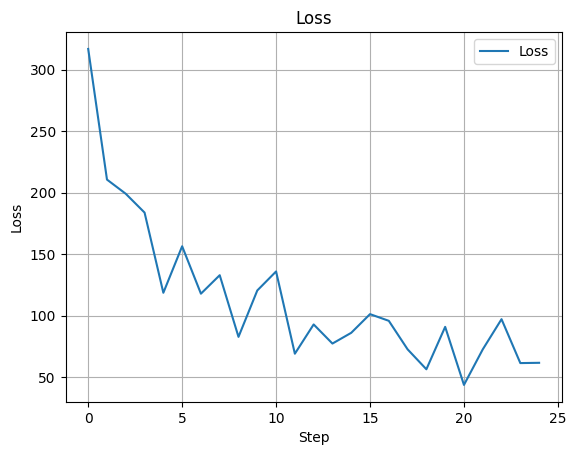

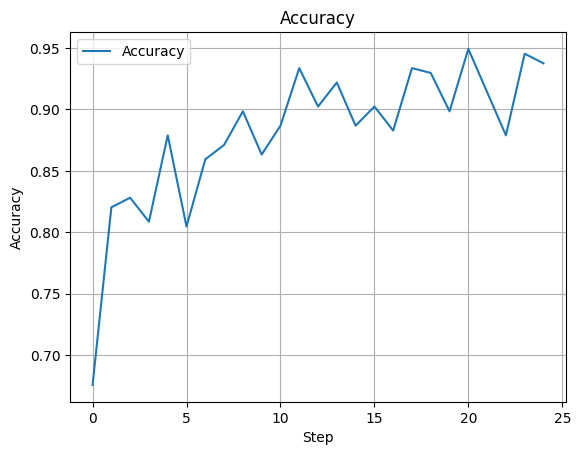

In [9]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label='Loss')
plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
final_pred_train = neural_net(x_train)
final_acc_train = accuracy(final_pred_train, y_train)
print(f'Training Accuracy: {final_acc_train}')

# Тестування моделі на тестових даних
# Місце для вашого коду
pred_test = neural_net(x_test)
acc_test = accuracy(pred_test, y_test)
print(f'Test Accuracy: {acc_test}')

Training Accuracy: 0.9173499941825867
Test Accuracy: 0.8996000289916992


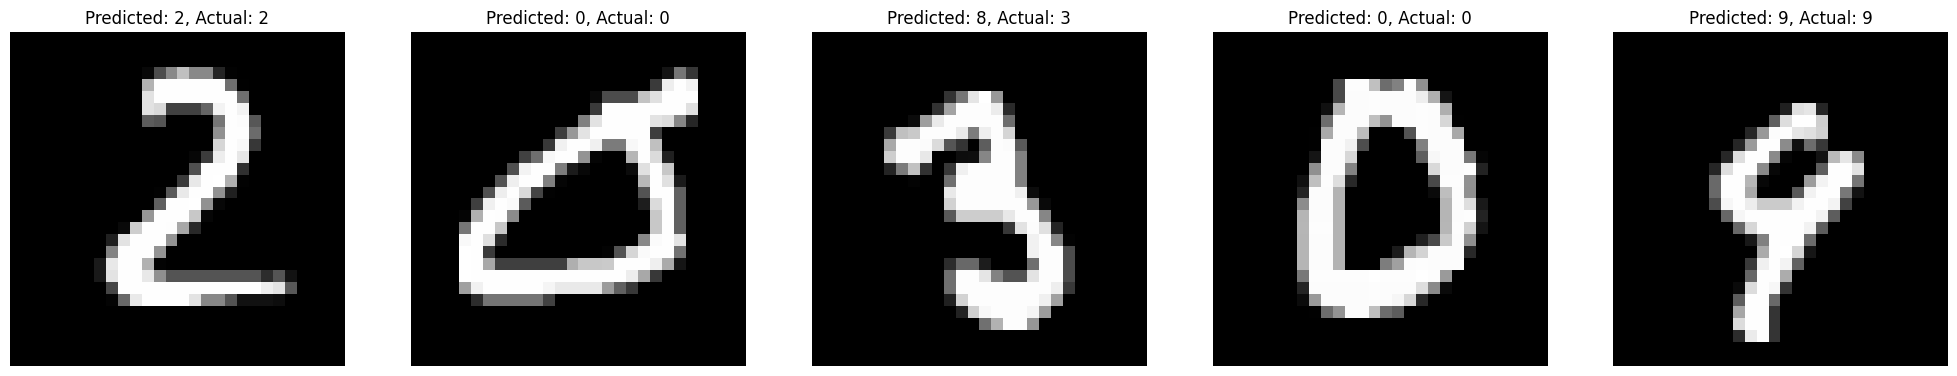

In [11]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
# Виберіть 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# Передайте обрані зображення в нейронну мережу
predictions = neural_net(images_to_test)

# Виведіть зображення та випишіть поруч відповідь нейромережі
plt.figure(figsize=(25, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_to_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, Actual: {labels_to_test[i]}")
    plt.axis('off')
plt.show()



In [12]:
from sklearn.metrics import classification_report

# Передбачення для тренувальної вибірки
train_predictions = neural_net(x_train)

# Отримати індекси класів з передбачень
predicted_classes = tf.argmax(train_predictions, axis=1)

# Отримати classification report
report = classification_report(y_train, predicted_classes.numpy())

# Вивести звіт
print(report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5923
           1       0.97      0.98      0.97      6742
           2       0.89      0.91      0.90      5958
           3       0.91      0.86      0.89      6131
           4       0.91      0.92      0.91      5842
           5       0.88      0.88      0.88      5421
           6       0.95      0.94      0.95      5918
           7       0.94      0.92      0.93      6265
           8       0.87      0.90      0.88      5851
           9       0.89      0.89      0.89      5949

    accuracy                           0.92     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.92      0.92      0.92     60000



Загальна точність (accuracy) у даному випадку складає 92%, що досить високо. Це означає, що модель правильно класифікує більшість зразків.

Проте, важливо також звернути увагу на метрики precision, recall та F1-показник для кожного класу. Адже, якщо precision висока, а recall низька для певного класу, це може вказувати на те, що модель часто помиляється, коли класифікує цей клас, або що вона пропускає багато екземплярів цього класу. Тому важливо збалансувати precision та recall для всіх класів.

Отже, з аналізу вказаних метрик можна зробити висновок про те, що нейронна мережа виявилася досить ефективною, але можливість поліпшення існує, зокрема, шляхом покращення роботи з певними класами або налаштуванням параметрів моделі.